In [2]:
# For Development and debugging:
# Reload modul without restarting the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import socket
import sys
import copy

In [7]:
# Load external libraries
key = 'external_libs_path'
if socket.gethostname() == 'hughes-machine':
    external_libs_path = '/home/hhughes/Documents/Master_Thesis/Project/workspace/libs'
else:
    external_libs_path= '/storage/groups/ml01/code/andres.becker/master_thesis/workspace/libs'
print('External libs path: \n'+external_libs_path)

if not os.path.exists(external_libs_path):
    msg = 'External library path {} does not exist!'.format(external_libs_path)
    raise Exception(msg)

# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
sys.path.insert(1, external_libs_path)

import Utils as utils
from Utils import print_stdout_and_log as printc
from Utils import set_GPU_config as set_GPU_config
import tfds_utils

External libs path: 
/home/hhughes/Documents/Master_Thesis/Project/workspace/libs


In [12]:
# Load parameters
# Do not touch the value of PARAMETERS_FILE!
# When this notebook is executed with jupyter-nbconvert (from script), 
# it will be replaced outomatically
PARAMETERS_FILE = '/home/hhughes/Documents/Master_Thesis/Project/workspace/scripts/Parameters/model_params/local/Quick_test_local.json'
#PARAMETERS_FILE = 'dont_touch_me-input_parameters_file'

# Open parameters
if os.path.exists(PARAMETERS_FILE):
    with open(PARAMETERS_FILE) as file:
        p = json.load(file)
else:
    raise Exception('Parameter file {} does not exist!'.format(PARAMETERS_FILE))

p["tf_ds_name"] = "mpp_ds__normal_dmso_roar_bl"
p["local_tf_datasets"] = "/data/Master_Thesis_data/datasets/tensorflow_datasets"


# look for missing parameters and set default values
p['parameters_file_path'] = PARAMETERS_FILE
p['external_libs_path'] = external_libs_path
# check and set default parameters
p, info = utils.set_model_default_parameters(p)
print(info)
print(p.keys())


Input parameters:

  Model parameters:
    Selected model: Linear_Regression
    Instantiate custom model class: 1
    Pretraining: 0
    Dense layers regularization (l1, l2): [0, 0]
    Conv layers regularization (l1, l2): [0, 0]
    Bias L2 reg (for dense and conv layers): 0
    Number of epochs: 35
    Early stop patience: 100
    Loss function: huber
    Learning rate: 0.1
    Batch size: 1
    Verbose level: 1

  Output:
    Base name for files: Quick_test_local
    Model output: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/Linear_Regression/Quick_test_local
    Clean base_path? 1

  Dataset:
     TFDS name: mpp_ds__normal_dmso_roar_bl
    Selected input channels: 
    ['00_DAPI', '07_H2B', '01_CDK9_pT186', '03_CDK9', '05_GTF2B', '07_SETD1A', '08_H3K4me3', '09_SRRM2', '10_H3K27ac', '11_KPNA2_MAX', '12_RB1_pS807_S811', '13_PABPN1', '14_PCNA', '15_SON', '16_H3', '17_HDAC3', '19_KPNA1_MAX', '20_SP100', '21_NCL', '01_PABPC1', '02_CDK7', '03_RPS6', '05_Sm', '07_POLR2

In [13]:
# Set GPU config
set_GPU_config(p['disable_gpu'], p['set_memory_growth'])

Cuda devices (GPUs) disabled
Physical GPU devises:
[]
It was not possible to limit GPU memory


In [14]:
def get_top_score_map(score_map, cell_mask, percent):
    n_channels = score_map.shape[-1]
    n_pixels = n_channels * (score_map.shape[0]**2)

    cell_prop = np.sum(cell_mask) * n_channels / n_pixels
    top_percent = cell_prop * percent
    n_top_pixels = int(top_percent * n_pixels)
    # get top pixels
    boun_val = (-1 * np.sort(-1 * score_map, axis=None))[n_top_pixels]
    mask_tops = (score_map > boun_val)

    temp_score_map = copy.deepcopy(score_map)
    temp_score_map[~mask_tops] = 0
    
    return temp_score_map

In [79]:
sample_ids = ['373509']
#"_comment": "Path where the Score Maps are:-------------------------------",
score_maps_path = "/data/Master_Thesis_data/datasets/Score_Maps/VarGrad_IG/BL_RIV2_test4/data"
pp_data_path = "/data/Master_Thesis_data/datasets/184A1_hannah_imgs_no_split_test/data"

## Load Dataset

In [26]:
# Path where tf datasets are
dataset, ds_info = tfds.load(
    name=p['tf_ds_name'], 
    data_dir=p['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=False, 
    shuffle_files=p['shuffle_files'],
    with_info=True)

# Load splits
#train_data, val_data = dataset['train'], dataset['validation']

msg = 'Tensorflow dataset {} loaded from:\n{}'.format(p['tf_ds_name'], p['local_tf_datasets'])
printc(msg)

Tensorflow dataset mpp_ds__normal_dmso_roar_bl loaded from:
/data/Master_Thesis_data/datasets/tensorflow_datasets


In [27]:
print(ds_info.description)

Dataset containing images of Multiplexed protein maps.
The elements of this data sets are multichannel images of singel cells alongside with its transcription rate.
This Dataset was builded after a preprocessing using the python script Transform_MPPData_into_images_no_split_from_script.ipynb. During this preprocessing the original MPPData was:
- Converted into images.
- Cleaned. Border and mitotic cells were removed.
- Removed the background
- Target value (scalar) calculated. The transcription rate was approximated taking the average of the measured pixels of the channel 00_EU. It is important to mention that the the target value was calculated BEFORE the normalization process.

This Dataset contains only the cells with no perturbations (i.e. cells such that perturbation in ['normal', 'DMSO']). Although perturbations 'TSA' seams not to have influence over the TR (00_EU avg), it seams to have an influence on the intensity of the channel 10_H3K27ac, and therefore it is not included. Onl

In [28]:
ds_info.splits

{'test_0': <tfds.core.SplitInfo num_examples=57>,
 'test_10': <tfds.core.SplitInfo num_examples=57>,
 'test_20': <tfds.core.SplitInfo num_examples=57>,
 'test_30': <tfds.core.SplitInfo num_examples=57>,
 'test_40': <tfds.core.SplitInfo num_examples=57>,
 'test_50': <tfds.core.SplitInfo num_examples=57>,
 'test_60': <tfds.core.SplitInfo num_examples=57>,
 'test_70': <tfds.core.SplitInfo num_examples=57>,
 'test_80': <tfds.core.SplitInfo num_examples=57>,
 'test_90': <tfds.core.SplitInfo num_examples=57>,
 'train_0': <tfds.core.SplitInfo num_examples=449>,
 'train_10': <tfds.core.SplitInfo num_examples=449>,
 'train_20': <tfds.core.SplitInfo num_examples=449>,
 'train_30': <tfds.core.SplitInfo num_examples=449>,
 'train_40': <tfds.core.SplitInfo num_examples=449>,
 'train_50': <tfds.core.SplitInfo num_examples=449>,
 'train_60': <tfds.core.SplitInfo num_examples=449>,
 'train_70': <tfds.core.SplitInfo num_examples=449>,
 'train_80': <tfds.core.SplitInfo num_examples=449>,
 'train_90': <t

In [29]:
ds_info.features

FeaturesDict({
    'image': Tensor(shape=(224, 224, 34), dtype=tf.float32),
    'mapobject_id_cell': Text(shape=(), dtype=tf.string),
    'target': Tensor(shape=(1,), dtype=tf.float64),
})

In [30]:
# Load TFDS metadata
tfds_metadata = tfds_utils.Costum_TFDS_metadata().load_metadata(ds_info.data_dir)
tfds_metadata.keys()

dict_keys(['data_pp_parameters', 'channels_df', 'tfds_creation_parameters', 'metadata_df'])

In [31]:
channels_df = tfds_metadata['channels_df']
channels_df

,original_channel_id,name,train_98_percentile,train_mean_after_clipping,train_stddev_after_clipping,type,TFDS_channel_id
0,0.0,00_DAPI,70.300003,36.698181,13.724143,input,0.0
1,1.0,07_H2B,313.299988,179.147583,57.992622,input,1.0
2,2.0,01_CDK9_pT186,53.889076,14.996439,13.069974,input,2.0
3,3.0,03_CDK9,94.797798,28.636209,22.637976,input,3.0
4,4.0,05_GTF2B,192.166107,91.271889,46.906582,input,4.0
5,5.0,07_SETD1A,96.989853,24.174747,23.147612,input,5.0
6,6.0,08_H3K4me3,109.921074,40.807518,26.133425,input,6.0
7,7.0,09_SRRM2,271.374664,44.068733,61.584835,input,7.0
8,8.0,10_H3K27ac,185.104874,73.346092,45.748833,input,8.0
9,9.0,11_KPNA2_MAX,121.093430,53.586163,24.004549,input,9.0


In [55]:
metadata_df = tfds_metadata['metadata_df']
metadata_df.mapobject_id_cell = metadata_df.mapobject_id_cell.astype(str)
metadata_df

,mapobject_id_cell,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,plate_name_cell,well_name_cell,well_pos_y_cell,well_pos_x_cell,tpoint_cell,zplane_cell,label_cell,is_border_cell,is_mitotic,is_mitotic_labels,is_polynuclei_HeLa,is_polynuclei_HeLa_labels,is_polynuclei_184A1,is_polynuclei_184A1_labels,cell_cycle,cell_type,perturbation,duration,cell_size,00_DAPI_avg,07_H2B_avg,01_CDK9_pT186_avg,03_CDK9_avg,05_GTF2B_avg,07_SETD1A_avg,08_H3K4me3_avg,09_SRRM2_avg,10_H3K27ac_avg,11_KPNA2_MAX_avg,12_RB1_pS807_S811_avg,13_PABPN1_avg,14_PCNA_avg,15_SON_avg,16_H3_avg,17_HDAC3_avg,19_KPNA1_MAX_avg,20_SP100_avg,21_NCL_avg,01_PABPC1_avg,02_CDK7_avg,03_RPS6_avg,05_Sm_avg,07_POLR2A_avg,09_CCNT1_avg,10_POL2RA_pS2_avg,11_PML_avg,12_YAP1_avg,13_POL2RA_pS5_avg,15_U2SNRNPB_avg,18_NONO_avg,20_ALYREF_avg,21_COIL_avg,00_BG488_avg,00_BG568_avg,00_EU_avg,09_SRRM2_ILASTIK_avg,15_SON_ILASTIK_avg,cell_size_ratio,set
0,373506,373535,plate01,I09,0,0,0,0,6,0,plate01,I09,0,0,0,0,6,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,normal,NaN,12969.0,43.893030,175.995428,27.577226,54.206169,128.697294,41.469521,60.416069,64.842372,125.169772,65.557846,105.751293,192.479292,78.460671,49.046642,187.326717,99.378451,117.227410,26.282266,60.407161,33.006360,131.946547,28.173045,54.011811,187.774103,131.526724,385.672558,11.862217,81.837107,291.005551,51.128612,368.260323,285.676524,11.584543,8.256946,1.803026,599.449225,8305.377207,10121.675842,0.687500,train
1,373507,373536,plate01,I09,0,0,0,0,7,0,plate01,I09,0,0,0,0,7,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,9846.0,39.837376,273.655677,12.569294,22.001503,81.730022,20.032913,39.631146,44.481310,73.860256,54.789958,67.896671,162.914590,35.864765,37.245010,355.807515,67.943580,76.462250,12.614654,55.775873,14.612852,120.283067,19.574581,41.063924,101.116543,55.055405,297.648758,11.671538,91.374197,329.135675,33.598199,335.386680,410.320858,9.813957,5.888977,1.561608,398.334857,6055.847451,10278.970546,0.598214,val
2,373508,373537,plate01,I09,0,0,0,0,8,0,plate01,I09,0,0,0,0,8,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,7714.0,44.735922,258.942987,23.616477,47.406444,140.684383,44.831516,68.078372,67.289663,85.795525,90.090190,87.339633,249.505730,88.193348,51.833120,332.372822,124.072929,130.945283,38.285344,76.223063,43.566143,151.189717,39.663339,71.273700,205.703836,124.654347,332.255405,17.381051,196.612601,361.317387,55.593623,457.713302,469.516855,14.441616,9.757942,1.859657,464.431683,8280.577392,11757.616541,0.500000,test
3,373509,373538,plate01,I09,0,0,0,0,9,0,plate01,I09,0,0,0,0,9,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,normal,NaN,15718.0,43.931378,194.444293,18.353704,32.399117,104.564078,29.361877,46.617407,51.506499,127.183208,55.535536,94.269486,171.038290,77.086018,32.756867,212.862917,74.396402,81.701189,15.256486,49.931726,19.315464,136.797350,21.712636,45.183902,148.422635,82.323469,284.648928,8.077076,50.190543,271.552491,37.614959,285.612350,263.922204,7.988940,6.477020,1.717521,425.533338,7441.930589,8530.446240,0.678571,val
4,373510,373539,plate01,I09,0,0,0,0,10,0,plate01,I09,0,0,0,0,10,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,normal,NaN,12229.0,30.892690,231.842236,19.046228,37.117579,100.918987,25.272207,43.387094,43.176593,78.249253,76.013457,112.938592,178.444723,81.792631,41.639270,292.071767,90.931247,99.625565,27.330404,66.549839,20.411372,107.398853,23.828493,55.354041,134.139140,99.027838,301.044591,15.211128,122.575573,334.431894,42.139486,362.906348,438.364101,10.736532,6.967087,1.697280,410.540764,5541.760160,10350.776433,0.633929,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,248051,248096,plate01,I09,5,4,0,0,31,0,plate01,I09,5,4,0,0,31,0,0.0,NaN,0.0,NaN,0.0,NaN,G1,184A1,normal,NaN,11135.0,34.088505,155.096587,13.024716,28.9366

In [80]:
mask = metadata_df.mapobject_id_cell.isin(sample_ids)
metadata_df[mask]

,mapobject_id_cell,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,plate_name_cell,well_name_cell,well_pos_y_cell,well_pos_x_cell,tpoint_cell,zplane_cell,label_cell,is_border_cell,is_mitotic,is_mitotic_labels,is_polynuclei_HeLa,is_polynuclei_HeLa_labels,is_polynuclei_184A1,is_polynuclei_184A1_labels,cell_cycle,cell_type,perturbation,duration,cell_size,00_DAPI_avg,07_H2B_avg,01_CDK9_pT186_avg,03_CDK9_avg,05_GTF2B_avg,07_SETD1A_avg,08_H3K4me3_avg,09_SRRM2_avg,10_H3K27ac_avg,11_KPNA2_MAX_avg,12_RB1_pS807_S811_avg,13_PABPN1_avg,14_PCNA_avg,15_SON_avg,16_H3_avg,17_HDAC3_avg,19_KPNA1_MAX_avg,20_SP100_avg,21_NCL_avg,01_PABPC1_avg,02_CDK7_avg,03_RPS6_avg,05_Sm_avg,07_POLR2A_avg,09_CCNT1_avg,10_POL2RA_pS2_avg,11_PML_avg,12_YAP1_avg,13_POL2RA_pS5_avg,15_U2SNRNPB_avg,18_NONO_avg,20_ALYREF_avg,21_COIL_avg,00_BG488_avg,00_BG568_avg,00_EU_avg,09_SRRM2_ILASTIK_avg,15_SON_ILASTIK_avg,cell_size_ratio,set
3,373509,373538,plate01,I09,0,0,0,0,9,0,plate01,I09,0,0,0,0,9,0,0.0,NaN,0.0,NaN,0.0,NaN,S,184A1,normal,NaN,15718.0,43.931378,194.444293,18.353704,32.399117,104.564078,29.361877,46.617407,51.506499,127.183208,55.535536,94.269486,171.03829,77.086018,32.756867,212.862917,74.396402,81.701189,15.256486,49.931726,19.315464,136.79735,21.712636,45.183902,148.422635,82.323469,284.648928,8.077076,50.190543,271.552491,37.614959,285.61235,263.922204,7.98894,6.47702,1.717521,425.533338,7441.930589,8530.44624,0.678571,val


In [100]:
# Load degradated cells from TFDS
sample_cells = {}
sample_cells_mask = {}
for ds_key in [key for key in dataset.keys() if 'val' in key]:
    #print(ds_key)
    
    for cell in dataset[ds_key]:
        cell_id = cell['mapobject_id_cell'].numpy().decode()
        
        if cell_id in sample_ids:
            #print(cell_id)
            key = cell_id+'_'+ds_key.split("_")[1]
            sample_cells[key] = cell['image'].numpy()[:,:,0:-1]
            sample_cells_mask[cell_id] = cell['image'].numpy()[:,:,-1]
            break

In [102]:
# Load score maps
sample_score_maps = {}
for cell_id in sample_ids:
    temp_path = os.path.join(score_maps_path, cell_id+'.npy')
    sample_score_maps[cell_id] = np.load(temp_path)

In [132]:
score_map[cell_mask][disp_ids].min()

0.0001364733

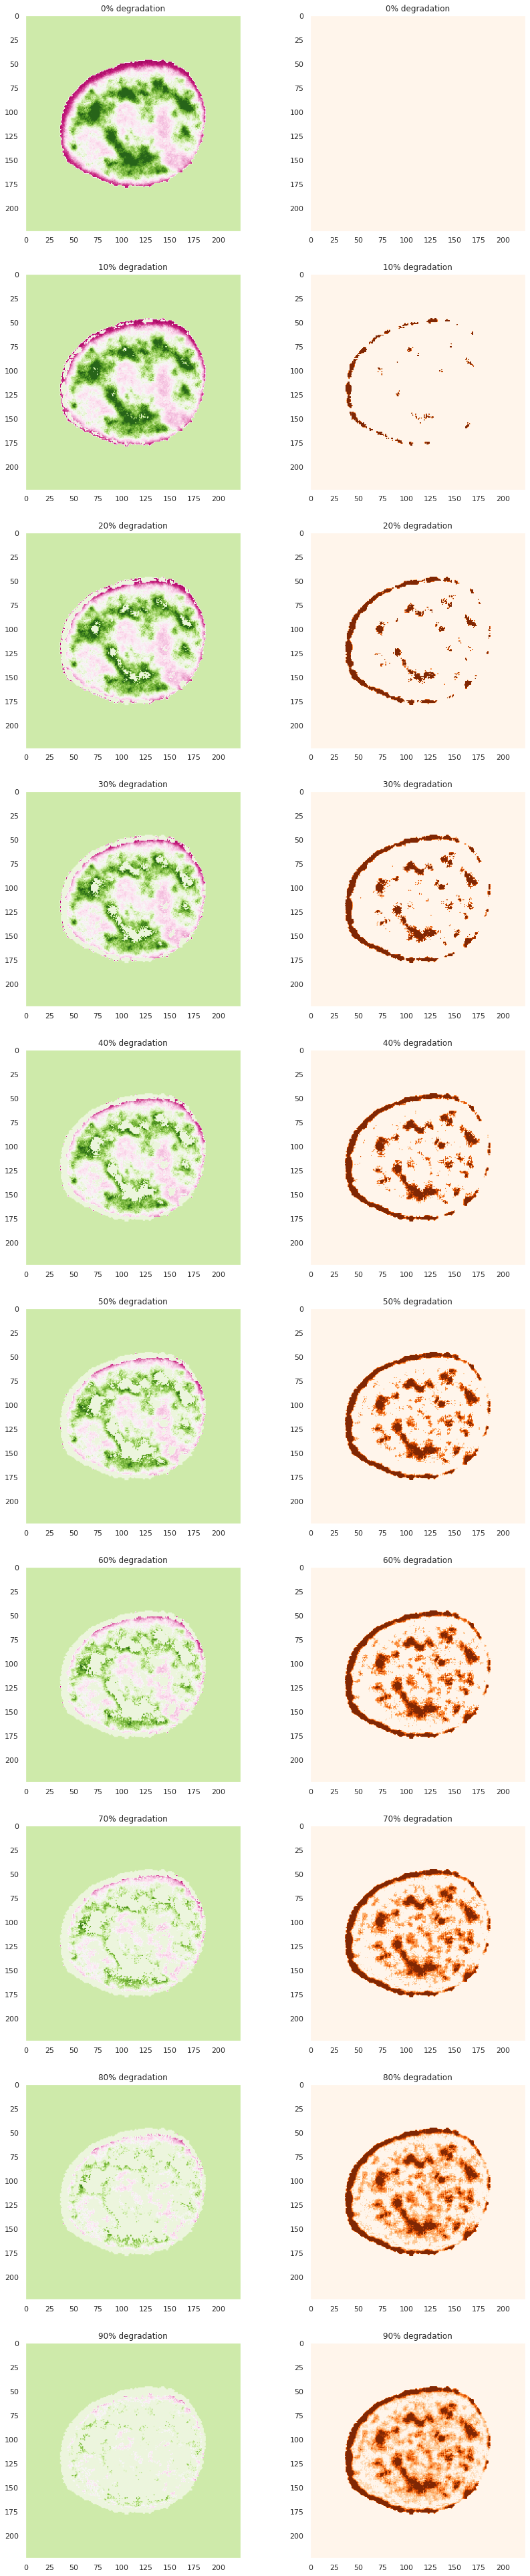

In [141]:
disp_ids = [25, 26, 4]
disp_ids = [31, 7, 13]
disp_ids = [31]

for cell_id in sample_ids:
    keys = [key for key in sample_cells.keys() if cell_id in key]
    keys.sort()
    
    n_rows = len(keys)
    n_columns = 2
    plt.figure(figsize=(2*7,n_rows*7))
    
    temp_img = sample_cells[cell_id+'_0']
    score_map = sample_score_maps[cell_id]
    cell_mask = sample_cells_mask[cell_id]
    cell_mask = cell_mask.astype(bool)
    
    vmin_sm = score_map[cell_mask][disp_ids].min()
    vmax_sm = score_map[cell_mask][disp_ids].max()
    
    vmin_img = temp_img[cell_mask][disp_ids].min()
    vmax_img = temp_img[cell_mask][disp_ids].max()
    
    plot_count = 0
    for cell_key in keys:
        cell_img = sample_cells[cell_key]
        percent = int(cell_key.split("_")[1]) / 100
        title = str(int(percent*100))+'% degradation'
        
        top_score_map = get_top_score_map(score_map, cell_mask, percent)
        #top_score_map = get_top_score_map(score_map, cell_mask, 1)

        # Degradated cell
        plot_count += 1
        plt.subplot(n_rows,n_columns,plot_count)
        plt.imshow(cell_img[:,:,disp_ids],
               cmap=getattr(plt.cm, 'PiYG'),
                   vmin=vmin_img, vmax=vmax_img,
               #cmap=getattr(plt.cm, 'Blues'),
               aspect='equal',
                )
        plt.title(title)
        plt.grid(False)
        # Top pixels from score map
        plot_count += 1
        plt.subplot(n_rows,n_columns,plot_count)
        plt.imshow(top_score_map[:,:,disp_ids],
                   cmap=getattr(plt.cm, 'Oranges'),
                   vmin=vmin_sm, vmax=vmax_sm,
                   #cmap=getattr(plt.cm, 'PiYG'),
               aspect='equal',
                )
        plt.title(title)
        plt.grid(False)
        

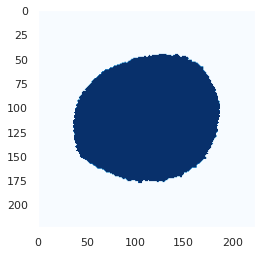

In [104]:
for sample_id in sample_ids:
    
    temp_img = sample_cells_mask[sample_id]
    plt.figure()
    plt.imshow(temp_img,
                   #cmap=getattr(plt.cm, 'PiYG'),
                   cmap=getattr(plt.cm, 'Blues'),
                   aspect='equal',
                    )
    plt.grid(False)

In [67]:
sample_cells_mask

{}

In [68]:
sample_cells

{}

In [69]:
sample_ids

['248051']

,mapobject_id_cell,mapobject_id,plate_name,well_name,well_pos_y,well_pos_x,tpoint,zplane,label,is_border,plate_name_cell,well_name_cell,well_pos_y_cell,well_pos_x_cell,tpoint_cell,zplane_cell,label_cell,is_border_cell,is_mitotic,is_mitotic_labels,is_polynuclei_HeLa,is_polynuclei_HeLa_labels,is_polynuclei_184A1,is_polynuclei_184A1_labels,cell_cycle,cell_type,perturbation,duration,cell_size,00_DAPI_avg,07_H2B_avg,01_CDK9_pT186_avg,03_CDK9_avg,05_GTF2B_avg,07_SETD1A_avg,08_H3K4me3_avg,09_SRRM2_avg,10_H3K27ac_avg,11_KPNA2_MAX_avg,12_RB1_pS807_S811_avg,13_PABPN1_avg,14_PCNA_avg,15_SON_avg,16_H3_avg,17_HDAC3_avg,19_KPNA1_MAX_avg,20_SP100_avg,21_NCL_avg,01_PABPC1_avg,02_CDK7_avg,03_RPS6_avg,05_Sm_avg,07_POLR2A_avg,09_CCNT1_avg,10_POL2RA_pS2_avg,11_PML_avg,12_YAP1_avg,13_POL2RA_pS5_avg,15_U2SNRNPB_avg,18_NONO_avg,20_ALYREF_avg,21_COIL_avg,00_BG488_avg,00_BG568_avg,00_EU_avg,09_SRRM2_ILASTIK_avg,15_SON_ILASTIK_avg,cell_size_ratio,set
